**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.matmul(lambda_vect, targ_vect_mult)
    return newFR


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N

    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new


### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, fr_curr, targ_vect):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = a_vect + np.dot(k_matx, np.squeeze(np.asarray(fr_curr)))
    return (cursor_pos)

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, fr_curr):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), fr_curr )
    # A = 2 x 1
    a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, cost_func_args)
#     a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
    a_next = a_vect.copy().reshape(np.shape(a_grad))
    k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, cost_func_args)
    k_next = k_matx.copy() - k_rate*k_grad
#     k_next = k_matx.copy()
    return (a_next, k_next)

    
    

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
  norm_vect = np.array(y_vect) - np.array(t_vect)
  return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    decoder_params, firing_rate = cost_func_params
    y_vect = decoder_findY(decoder_params, firing_rate, TARGET_VECTOR_ERR)
    t_vect = TARGET_VECTOR_ERR
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, curr_fr) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            perturb_rand[iN, iC, :] = np.random.normal(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, input_perturb)   
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, input_fr)

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, input_fr)   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, fr_init)
    

    num_neurons = np.size(fr_init, 0)

    # Load display stuff
    figsize = (fig_x , fig_y)
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,3,1); ax1.grid('on')
    ax2 = plt.subplot(1,3,2); ax2.grid('on')
    ax3 = plt.subplot(1,3,3); ax3.grid('on')
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, num_iter) )
        fr_vect[:, [0]] = fr_init #fr init = num_neurons x 1
        fr_final = np.zeros((num_neurons, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str(fr_vect[:, [0]]))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, iT+1] = fr_next
            

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            grad_args_next = (decoder_init, fr_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next


            # calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next
        ax1.plot(range(num_iter), err_vect, label=fr_sigma)
        
        
        for iN in range(num_neurons):
            ax2.plot(range(num_iter), fr_vect[iN, :], label=fr_sigma)  
#             ax3.plot(range(numIter), lambda_vect[iN, 0, :], label = 'b') 
            ax3.plot(range(num_iter), lambda_vect[iN, 1, :], label = 'Wx, sigma =' + str(fr_sigma)) 
            # ax3.plot(range(numIter), lambda_vect[iN, 2, :], label = 'Wy, sigma =' + str(fr_sigma))

        # Draw results
        ax1.set_ylabel('$RE$', color='white')
        ax1.set_xlabel('iteration', color='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.tick_params(axis='y', colors='white')
        ax1.set_title('RE' + ' N = ' + str(fr_dist_size) + ' Rate = ' + str(lambda_rate), color='white')
        ax1.legend()

        # ax2.plot(range(it_num),u_new)
        ax2.set_ylabel('$FR$', color='white')
        ax2.set_xlabel('iteration', color='white')
        ax2.tick_params(axis='x', colors='white')
        ax2.tick_params(axis='y', colors='white')
        ax2.set_title('FR', color='white')
        ax2.legend()

        ax3.set_ylabel('$lambda$', color='white')
        ax3.set_xlabel('iteration', color='white')
        ax3.tick_params(axis='x', colors='white')
        ax3.tick_params(axis='y', colors='white')
        ax3.set_title('Lambda', color='white')
        ax3.legend()

    return (re_final, fr_final, lambda_final)

### Stochastic Gradient Descent: Update Brain + Adapter and Recalculate Error

In [7]:
def brain_decoder_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, fr_init)
    

    num_neurons = np.size(fr_init, 0)

    # Load display stuff
    figsize = (fig_x , fig_y)
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,3,1); ax1.grid('on')
    ax2 = plt.subplot(1,3,2); ax2.grid('on')
    ax3 = plt.subplot(1,3,3); ax3.grid('on')
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, num_iter) )
        fr_vect[:, [0]] = fr_init #fr init = num_neurons x 1
        fr_final = np.zeros((num_neurons, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str(fr_vect[:, [0]]))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            #   # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, iT+1] = fr_next
            
#             # Update decoder as well
#             calcNextDecoder(a_param, a_rate, a_param_dist, k_param, k_rate, k_param_dist, curr_fr)
    
            # Update parameters for calculating error
    
              #   ## calculate the new cost
              #   # (3) Calculate the new reach error 
#             fr_update = fr_next.copy().reshape(num_neurons, 1)
            grad_args_next = (decoder_init, fr_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next
            print('next error = ' + str(err_next))

              #   ## calculate the next error descent term
            # to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, grad_args_next)
        
        fr_final[:, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next
        ax1.plot(range(num_iter), err_vect, label=fr_sigma)
        
        
        for iN in range(num_neurons):
            ax2.plot(range(num_iter), fr_vect[iN, :], label=fr_sigma)  
#             ax3.plot(range(numIter), lambda_vect[iN, 0, :], label = 'b') 
            ax3.plot(range(num_iter), lambda_vect[iN, 1, :], label = 'Wx, sigma =' + str(fr_sigma)) 
            # ax3.plot(range(numIter), lambda_vect[iN, 2, :], label = 'Wy, sigma =' + str(fr_sigma))

        # # Draw results
        ax1.set_ylabel('$RE$', color='white')
        ax1.set_xlabel('iteration', color='white')
        ax1.tick_params(axis='x', colors='white')
        ax1.tick_params(axis='y', colors='white')
        ax1.set_title('RE' + ' N = ' + str(fr_dist_size) + ' Rate = ' + str(lambda_rate), color='white')
        ax1.legend()

        # # ax2.plot(range(it_num),u_new)
        ax2.set_ylabel('$FR$', color='white')
        ax2.set_xlabel('iteration', color='white')
        ax2.tick_params(axis='x', colors='white')
        ax2.tick_params(axis='y', colors='white')
        ax2.set_title('FR', color='white')
        ax2.legend()

        ax3.set_ylabel('$lambda$', color='white')
        ax3.set_xlabel('iteration', color='white')
        ax3.tick_params(axis='x', colors='white')
        ax3.tick_params(axis='y', colors='white')
        ax3.set_title('Lambda', color='white')
        ax3.legend()

#     print("FR = " + str(fr_final))
#     print("diff in FR = " + str(fr_final - fr_init))
#     print("final lambda = " + str(lambda_final))
#     print("RE = " + str(re_final))
    
    return (re_final, fr_final, lambda_final)

### Set initial conditions

In [8]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = N x 1
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

BASELINE = np.array([5, 10, 15, 20])
NUM_NEURONS = len(BASELINE)
NUM_ITER = 50

# lambda
lambda_init = np.zeros((NUM_NEURONS, 3))
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_y

# target position
TARGET_VECTOR = np.array( [2 ,3])
TARGET_ERROR = np.array([0, 2])
TARGET_VECTOR_ERR = TARGET_VECTOR + TARGET_ERROR

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 
# fr_init[:, 0] = np.array(BASELINE)

# decoder initial paramters
K_MATX = np.random.random_sample( (2, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (TARGET_VECTOR_ERR - np.matmul(K_MATX, BASELINE))

# SGD initial parameters
# IMPORTANT!
FR_VAR = 1
A_VAR = 2
K_VAR = 3
# Brain
rate_list = [5e-3, 1e-3, 5e-4]
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
A_RATE = 1e-1
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 16
fig_y = 4


### Run through iterations

rate = 0.005
starting fr vect = [[20.8]
 [36.2]
 [37. ]
 [34. ]]
initial error = 2695.3122118372908
FR = [[10.59957963]
 [26.94975371]
 [19.50382306]
 [ 7.09311483]]
final lambda = [[[ 4.65998599e+00]
  [-2.80028025e-01]
  [ 1.29992994e+00]]

 [[ 9.69165846e+00]
  [-1.66830862e-02]
  [ 3.45829228e+00]]

 [[ 1.44167941e+01]
  [-1.66411796e-01]
  [ 1.08397051e+00]]

 [[ 1.91031038e+01]
  [ 2.06207655e-01]
  [-2.48448086e+00]]]
RE = [0.13261309]
rate = 0.001
starting fr vect = [[20.8]
 [36.2]
 [37. ]
 [34. ]]
initial error = 2695.3122118372908
FR = [[ 8.77476327]
 [23.8110611 ]
 [22.35169679]
 [ 7.54637213]]
final lambda = [[[ 4.59915878]
  [-0.40168245]
  [ 0.99579388]]

 [[ 9.58703537]
  [-0.22592926]
  [ 2.93517685]]

 [[14.51172323]
  [ 0.02344645]
  [ 1.55861613]]

 [[19.1182124 ]
  [ 0.23642481]
  [-2.40893798]]]
RE = [0.54411476]
rate = 0.0005
starting fr vect = [[20.8]
 [36.2]
 [37. ]
 [34. ]]
initial error = 2695.3122118372908
FR = [[ 7.34762878]
 [23.16227987]
 [22.18097512]
 [1

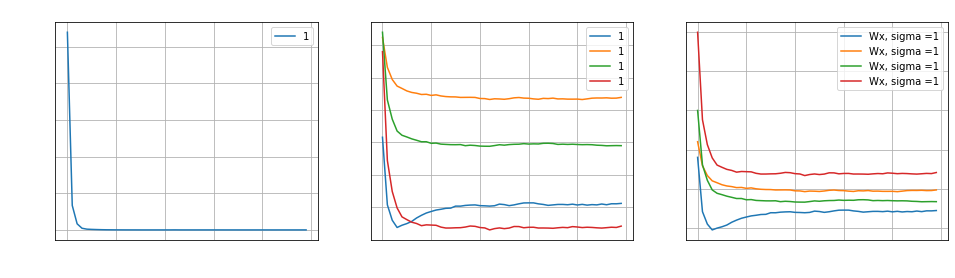

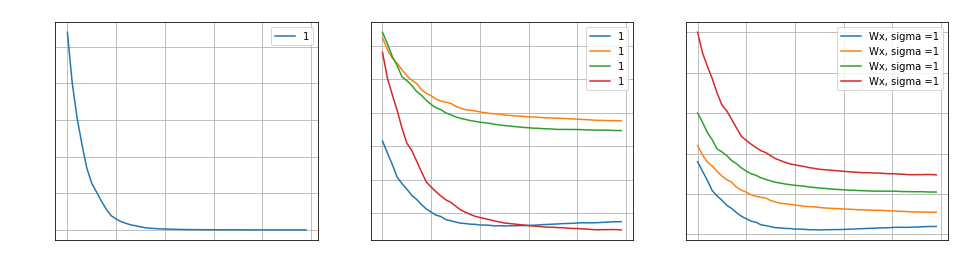

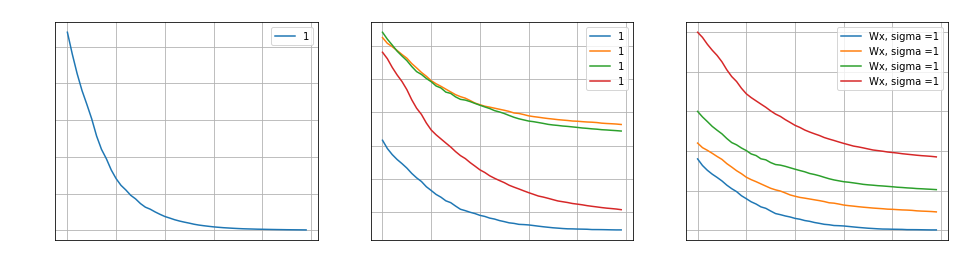

In [10]:
for rate in rate_list:
    ## BRAIN SIDE
    # (sigma, delta, num_dist) = param_dist
    
    FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    fr_init[:, 0] = brainFiringRate(lambda_init, TARGET_VECTOR_ERR)

    #(fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    brain_params_init = (fr_init, FR_DIST, lambda_init, rate)
    
    ## DECODER SIDE
    A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
    K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)
    decoder_params_init = (A_VECT, A_RATE, A_DIST, K_MATX, K_RATE, K_DIST)
    
    print("=================================")
    print("rate = " + str(rate))
    (re_final, fr_final, lambda_final) = brain_adapt_sgd(brain_params_init, decoder_params_init, TARGET_VECTOR_ERR, NUM_ITER)
    
    print("FR = " + str(fr_final))
#     print("diff in FR = " + str(fr_final - fr_init))
    print("final lambda = " + str(lambda_final))
    print("RE = " + str(re_final))
